In [2]:
%matplotlib inline
data = pd.read_pickle("songs_paul.pkl")

[ERROR] This trial license of GraphLab Create assigned to bninopaul@gmail.com has expired. Please contact trial@dato.com for licensing options or to request a free non-commercial license for personal or academic use.



In [3]:
data.head()

,artist,song,signal,sample_rate,channel
0,Pink,Are We All We Are,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",44100,2
1,Pink,Blow Me One Last Kiss,"[-9, -14, -10, -9, -11, -11, -9, -12, -11, -10...",44100,2
2,Pink,Try,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",44100,2
3,Pink,Just Give Me A Reason,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",44100,2
4,Pink,True Love,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",44100,2


In [16]:
%pylab inline
from utils import wavfilePlayer
from scipy.io import wavfile
index = 501
wavfile.write("sample.wav", data.ix[index]['sample_rate'], data.ix[index]['signal'])
display(wavfilePlayer.wavPlayer("sample.wav"))
print "Song: {}\nArtist: {}".format(data.ix[index]['song'], data.ix[index]['artist'])

Populating the interactive namespace from numpy and matplotlib


Song: Loyal
Artist: Chris Brown


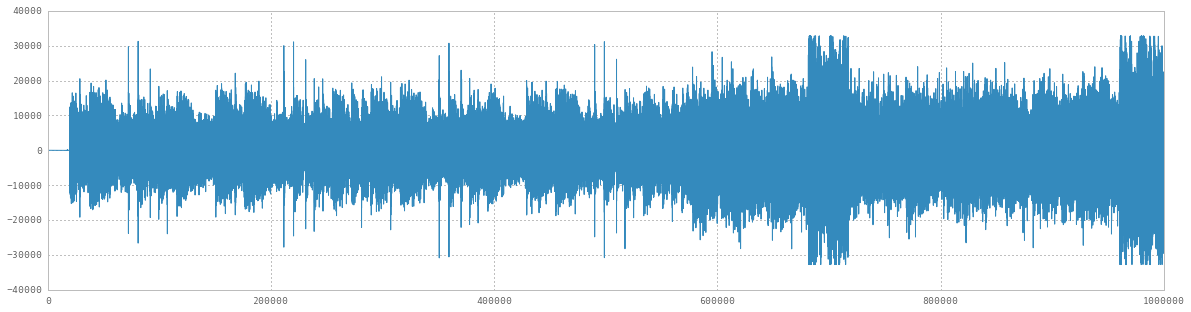

In [26]:
index = 0
sample = data.ix[index]['signal']
rate = data.ix[index]['sample_rate']
plt.figure(figsize = (20, 5))
plt.plot(sample[:1000000])

In [27]:
def segment_music(df,num_secs):
    segments = []
    for i in df.index:
        song = df.ix[i]['signal']
        num_pts = df.ix[i]['sample_rate']*num_secs
        trimmed = np.trim_zeros(song)
        seg_beg = trimmed[:num_pts]
        seg_mid = trimmed[int(trimmed.shape[0]/2)-(num_pts/2):int(trimmed.shape[0]/2)+(num_pts/2)]
        seg_end = trimmed[-num_pts:]
        segments.append([seg_beg,seg_mid,seg_end])
    return segments

In [28]:
segments = segment_music(data, 30)
data['segment_beg'] = map(lambda x: x[0], segments)
data['segment_mid'] = map(lambda x: x[1], segments)
data['segment_end'] = map(lambda x: x[2], segments)

In [20]:
data.head()

,artist,song,signal,sample_rate,channel,segment_beg,segment_mid,segment_end
0,Pink,Are We All We Are,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",44100,2,"[-1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[4502, 4882, 5043, 4242, 3328, 3123, 2721, 213...","[16448, 17526, 18439, 17593, 13771, 8368, 3233..."
1,Pink,Blow Me One Last Kiss,"[-9, -14, -10, -9, -11, -11, -9, -12, -11, -10...",44100,2,"[-9, -14, -10, -9, -11, -11, -9, -12, -11, -10...","[-21642, -22164, -20812, -20917, -22107, -2208...","[-10354, -9495, -7790, -6376, 1590, 7864, 1191..."
2,Pink,Try,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",44100,2,"[-1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[-3781, -2791, -2189, -1502, -782, -468, -761,...","[13418, 14179, 12476, 10395, 8173, 7343, 10015..."
3,Pink,Just Give Me A Reason,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",44100,2,"[-1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[-6072, -6576, -6950, -6696, -5653, -3965, -18...","[-626, -256, 584, 1901, 3315, 4537, 5400, 5956..."
4,Pink,True Love,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",44100,2,"[-1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[-15014, -19098, -18029, -17997, -16174, -1636...","[18431, 24020, 31532, 32767, 27869, 25101, 263..."


### Features

In [50]:
import librosa as lb

Spectral Centroid

In [272]:
def _partition(signal, window_length, jump):
    """
    Params:
    signal: (one-dimensional array)
    window_length: (int) size of the window/frame
    jump: (int) length of distance between windows/frames
    
    Return:
    partitions: (list) list of partitioned windows/frames of length window_length and 
    """
    signal_length = len(signal)
    signal_index = range(signal_length - window_length)
    beg_index = np.array(filter(lambda x: x%jump==0, signal_index))
    end_index = beg_index + window_length
    zipped = zip(beg_index, end_index)
    
    partitions = [signal[i[0]:i[1]] for i in zipped]
    return partitions

In [273]:
#Source: https://en.wikipedia.org/wiki/Spectral_centroid
def _spectral_centroid(signal, rate):
    """
    Params:
    signal: (one-dimensional array)
    rate: (int) sampling rate of the audio signal

    Return:
    spectral_centroid:(float) 
    """
    fft_mag = np.abs(np.fft.rfft(signal))
    freq = np.fft.rfftfreq(len(signal), 1/rate)
    spectral_centroid = np.dot(fft_mag, freq)/sum(fft_mag)
    return spectral_centroid

In [274]:
def spectral_centroid_meanstd(signal, rate, window_length, jump):
    """
    Params:
    signal:(one-dimensional array)
    rate: (int) sampling rate of the audio signal
    window_length: (int) see _partition()
    jump: (int) see_partition()
    
    Return:
    centroid_mean: (float) mean of the spectral centroids of a signal
    centroid_std: (float) standard deviation of the spectral centroids of a signal
    """
    partitions = _partition(signal, window_length, jump)
    centroids = map(lambda x: _spectral_centroid(x, rate), partitions)
    centroid_mean = np.mean(centroids)
    centroid_std = np.std(centroids)
    return centroid_mean, centroid_std

In [275]:
spectral_centroid_meanstd(sample, rate, rate, rate)

(3245.9162490295521, 440.80881943983172)

In [261]:
spec_centroid = lb.feature.spectral_centroid(sample, sr = rate, n_fft=rate, hop_length=rate)
spec_centroid.mean(), spec_centroid.std()

(3256.6105000548023, 504.78812322491126)

Spectral Roll Off

In [194]:
#Source: http://webhome.csc.uvic.ca/~gtzan/output/tsap02gtzan.pdf
def _spectral_rolloff(signal):
    """
    Params:
    signal: (one-dimensional array)
    
    Return:
    spectral_rolloff: (float) spectral roll-off of the signal
    """
    fft_mag = np.abs(np.fft.rfft(signal))
    dist85 = 0.85*sum(fft_mag)
    cumsum = np.cumsum(fft_mag)
    lessdist85 = cumsum<dist85
    spectral_rolloff = np.sum(lessdist85)
    return spectral_rolloff

In [195]:
def spectral_rolloff_meanstd(signal, window_length, jump):
    """
    Params:
    signal: (one-dimensional array)
    window_length: (int) see _partition()
    jump: (int) see _partition()
    
    Return:
    roll_off_mean: (float) mean of the spectral roll-offs of the windows generated from the signal
    roll_off_std: (float) standard deviation of the spectral roll-offs of the windows generated from the signal
    """
    partitions = _partition(signal, window_length, jump)
    roll_offs = map(lambda x: _spectral_rolloff(x), partitions)
    roll_off_mean = np.mean(roll_offs)
    roll_off_std = np.std(roll_offs)
    return roll_off_mean, roll_off_std

In [196]:
spectral_rolloff_meanstd(sample, rate, rate)

(6760.6682027649767, 1185.414174660752)

In [197]:
roll_off = lb.feature.spectral_rolloff(sample, sr = rate, n_fft = rate, hop_length=rate)
roll_off.mean(), roll_off.std()

(6755.2935779816517, 1323.3598143421307)

Spectral Flow/Spectral Flux

In [198]:
#Source: http://webhome.csc.uvic.ca/~gtzan/output/tsap02gtzan.pdf
#spectral flow and spectral flux are the same thing.
def spectral_flow_meanstd(signal, window_length, jump):
    """
    Params:
    signal: (one-dimensional array)
    window_length: (int) see _partition()
    jump: (int) see _partition()
    
    Return:
    flow_mean: (float) mean of the spectral flow of the signal
    flow_std: (float) standard deviation of the spectral flow of the signal
    """
    partitions = _partition(signal, window_length, jump)
    normalized_partitions = map(lambda x: x.astype(int)/np.linalg.norm(x.astype(int)), partitions)
    Nt = np.array(normalized_partitions[1:])
    Nt1 = np.array(normalized_partitions[:len(normalized_partitions)-1])
    Ft = np.sum((Nt - Nt1)**2, axis = 1)
    flow_mean = Ft.mean()
    flow_std = Ft.std()
    return flow_mean, flow_std
    

In [199]:
spectral_flow_meanstd(sample, rate, rate)

(2.0029416829739826, 0.070835142382250735)

Zero-Crossing Rate Mean

In [235]:
#Source: http://webhome.csc.uvic.ca/~gtzan/output/tsap02gtzan.pdf
def zero_crossing_rate_meanstd(signal, window_length, jump):
    """
    Params:
    signal: (one-dimensional array)
    window_length: (int) see _partition()
    jump: (int) see _partition()
    
    Return:
    zero_crossing_rate_mean: (float) mean of the zero crossing rates of the windows
    zero_crossing_rate_std: (float) standard deviation of the zero crossing rates of the windows
    """
    
    partitions = np.array(_partition(signal, window_length, jump))
    m,n = partitions.shape
    sign, sign1 = partitions[:, 1:]>0, partitions[:, :n-1]>0
    zero_crossing_rate  = (np.sum(np.abs(sign - sign1), axis = 1))/n
    zero_crossing_rate_mean = zero_crossing_rate.mean()
    zero_crossing_rate_std = zero_crossing_rate.std()
    return zero_crossing_rate_mean, zero_crossing_rate_std

In [236]:
zero_crossing_rate_meanstd(sample, rate, rate)

(0.067456764579871889, 0.018277169880250941)

In [230]:
zero_crossing_rate = lb.feature.zero_crossing_rate(sample, rate, rate)
zero_crossing_rate.mean(), zero_crossing_rate.std()

(0.069042418190517804, 0.018771809224226693)

Low Energy 

In [245]:
def rms_energy(signal):
    """
    Params:
    signal: (one-dimensional array)
    
    Return:
    rmsenergy: (float) root mean square energy of the signal
    """
    
    rmsenergy = np.sqrt(np.mean(signal**2))
    return rmsenergy

In [257]:
#Source(definition of RMS energy): http://blog.prosig.com/2015/01/06/rms-from-time-history-and-fft-spectrum/
#SOurce(definition of low energy feature): 
def lowenergy_feature(signal, aw_windowlength, tw_windowlength, jump):
    """
    Params:
    signal: (one-dimensional array)
    aw_windowlength: (int) window length of the analysis windows
    tw_windowlength: (int) window length of the texture windows
    jump: (int) see _partition()
    
    Return:
    lowenergy_percentage: (float) between 0-1,the percentage of analysis windows that have less
                            RMS energy than the average RMS energy across the texture window
    """
    if tw_windowlength< aw_windowlength:
        raise ValueError
    signal = signal.astype(int)
    partitions_analysis = _partition(signal, aw_windowlength, jump)
    partitions_texture = _partition(signal, tw_windowlength, jump)
    rmsenergy_analysis = map(lambda x: rms_energy(x), partitions_analysis)
    rmsenergy_texture = map(lambda x: rms_energy(x), partitions_texture)
    ave_rmsenergy_texture = np.mean(rmsenergy_texture)
    lowenergy_percentage = np.mean(rmsenergy_analysis<ave_rmsenergy_texture)
    return lowenergy_percentage

In [255]:
lowenergy_feature(sample, rate, rate*5, rate)

0.52995391705069128